In [5]:
import argparse
import os
import torch
import torch.backends.cudnn as cudnn
import numpy as np
import PIL.Image as pil_image
from ssim import SSIM
from models import FSRCNN
from utils import convert_ycbcr_to_rgb, preprocess, calc_psnr
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [3]:
if __name__ == '__main__':
    '''
    参数列表，--weight_file 表示权重文件
            --image-file-dir 表示预测图像文件夹
            --image-file-out-dir 表示预测图像的输出文件夹
            --scale表示采样比例
    '''
    parser = argparse.ArgumentParser()
    parser.add_argument('--weights-file', default="BLAH_BLAH/fsrcnn_x3.pth", type=str, required=False)
    parser.add_argument('--image-file-dir', default="Set5/", type=str, required=False)
    parser.add_argument('--image-file-out-dir', default="output/", type=str, required=False)
    parser.add_argument('--scale', type=int, default=3)
    args = parser.parse_args(args=[])
    
    cudnn.benchmark = True
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    # 实例化FSRCNN模型
    model = FSRCNN(scale_factor=args.scale).to(device)
    #加载模型参数字典
    state_dict = model.state_dict()
    for n, p in torch.load(args.weights_file, map_location=lambda storage, loc: storage).items():
        if n in state_dict.keys():
            state_dict[n].copy_(p)
        else:
            raise KeyError(n)
    # 实例化SIMM损失函数
    ssim_loss = SSIM()
    # 模型评估
    model.eval()
    # 对预测文件夹的每一个文件进行预测
    for image_name in os.listdir(args.image_file_dir):
        image = pil_image.open(os.path.join(args.image_file_dir, image_name)).convert('RGB')

        image_width = (image.width // args.scale) * args.scale
        image_height = (image.height // args.scale) * args.scale

        hr = image.resize((image_width, image_height), resample=pil_image.BICUBIC)
        lr = hr.resize((hr.width // args.scale, hr.height // args.scale), resample=pil_image.BICUBIC)
        bicubic = lr.resize((lr.width * args.scale, lr.height * args.scale), resample=pil_image.BICUBIC)
        # 下采样
        bicubic.save(
            os.path.join(args.image_file_out_dir, image_name.replace('.', '_bicubic_x{}.'.format(args.scale))))

        lr, _ = preprocess(lr, device)
        hr, _ = preprocess(hr, device)
        _, ycbcr = preprocess(bicubic, device)
        # 预测
        with torch.no_grad():
            preds = model(lr).clamp(0.0, 1.0)
        
        psnr = calc_psnr(hr, preds)
        print('PSNR: {:.2f}'.format(psnr))
        print('SSIM: {:.2f}'.format(ssim_loss(hr, preds)))

        preds = preds.mul(255.0).cpu().numpy().squeeze(0).squeeze(0)

        output = np.array([preds, ycbcr[..., 1], ycbcr[..., 2]]).transpose([1, 2, 0])
        output = np.clip(convert_ycbcr_to_rgb(output), 0.0, 255.0).astype(np.uint8)
        output = pil_image.fromarray(output)
        output.save(os.path.join(args.image_file_out_dir, image_name.replace('.', '_fsrcnn_x{}.'.format(args.scale))))

PSNR: 35.15
SSIM: 0.95
PSNR: 28.55
SSIM: 0.92
PSNR: 35.03
SSIM: 0.87
PSNR: 31.46
SSIM: 0.93
PSNR: 35.89
SSIM: 0.93


In [4]:
def img_show(axe,img,title):
    axes.imshow(img)
    axe.axis('off')
    axe.set_title(title)

In [8]:
def show_imgs(axes,img_name):
    image = mpimg.imread(os.path.join(args.image_file_dir, image_name))
    bicubic = mpimg.imread(os.path.join(args.image_file_out_dir, image_name.replace('.', '_bicubic_x{}.'.format(args.scale))))
    fsrcnn = mpimg.imread(os.path.join(args.image_file_out_dir, image_name.replace('.', '_fsrcnn_x{}.'.format(args.scale))))
    img_show(axes[0],image,"raw")
    img_show(axes[1],bicubic,"bicubic")
    img_show(axes[2],fsrcnn,"fsrcnn")

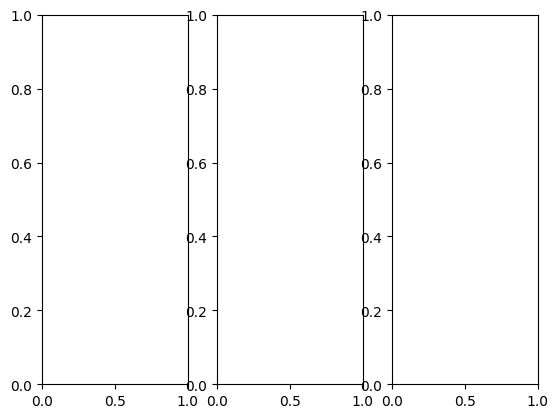

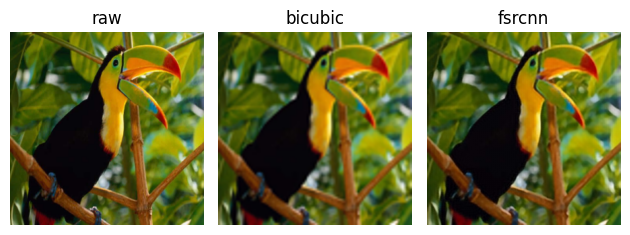

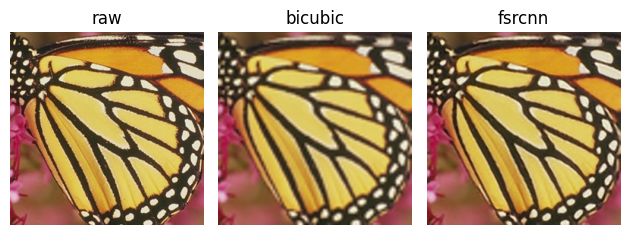

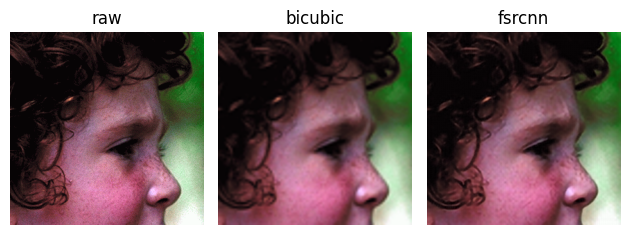

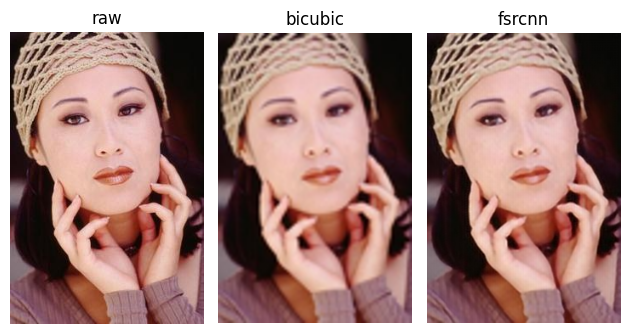

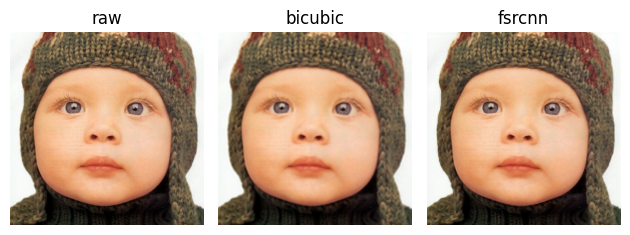

<Figure size 640x480 with 0 Axes>

In [9]:
fig, axes = plt.subplots(1, 3)
image_name = "baby.png"
show_imgs(axes,image_name)
plt.tight_layout()
plt.show()